![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from math import log
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, accuracy_score, explained_variance_score
from xgboost import XGBRegressor, plot_importance


# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

data.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [4]:
# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [6]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [7]:
# Celda 1
X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
def build_tree(X, y, max_depth, min_samples_split, depth=0):
    n_samples, n_features = X.shape
    
    # Comprobar si hemos alcanzado la profundidad máxima o si tenemos menos muestras que las muestras mínimas para dividir
    if depth >= max_depth or n_samples < min_samples_split:
        return np.mean(y)

    # Encontrar la característica y el umbral que minimizan el error
    best_loss = np.inf
    best_feature, best_threshold = None, None
    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            y_left = y[X[:, feature] < threshold]
            y_right = y[X[:, feature] >= threshold]
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            loss = np.sum((y_left - np.mean(y_left))**2) + np.sum((y_right - np.mean(y_right))**2)
            if loss < best_loss:
                best_loss = loss
                best_feature = feature
                best_threshold = threshold

    # Verificar si no pudimos encontrar una división que reduzca el error
    if best_feature is None:
        return np.mean(y)

    # Dividir los datos en nodos secundarios izquierdo y derecho
    left_indices = X[:, best_feature] < best_threshold
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[~left_indices], y[~left_indices]

    # Crear los nodos secundarios izquierdo y derecho
    left = build_tree(X_left, y_left, max_depth, min_samples_split, depth+1)
    right = build_tree(X_right, y_right, max_depth, min_samples_split, depth+1)

    # Crear el nodo actual
    return {'feature': best_feature, 'threshold': best_threshold, 'left': left, 'right': right}

In [11]:
# Construcción del árbol
max_depth = 5
min_samples_split = 10
tree = build_tree(X.values, y.values, max_depth, min_samples_split)

print(tree)

{'feature': 0, 'threshold': 2013, 'left': {'feature': 0, 'threshold': 2011, 'left': {'feature': 1, 'threshold': 99171, 'left': {'feature': 0, 'threshold': 2008, 'left': {'feature': 0, 'threshold': 2006, 'left': 7541.257425742574, 'right': 8834.25}, 'right': {'feature': 1, 'threshold': 64259, 'left': 11310.28735632184, 'right': 9652.621262458471}}, 'right': {'feature': 0, 'threshold': 2008, 'left': {'feature': 1, 'threshold': 132076, 'left': 7308.557142857143, 'right': 6506.493449781659}, 'right': {'feature': 1, 'threshold': 120880, 'left': 8634.1875, 'right': 7498.370535714285}}}, 'right': {'feature': 1, 'threshold': 87911, 'left': {'feature': 0, 'threshold': 2012, 'left': {'feature': 1, 'threshold': 64929, 'left': 11746.163461538461, 'right': 10840.979310344828}, 'right': {'feature': 1, 'threshold': 47544, 'left': 14624.463414634147, 'right': 12819.163855421686}}, 'right': {'feature': 1, 'threshold': 110541, 'left': {'feature': 0, 'threshold': 2012, 'left': 10273.895604395604, 'right'

In [12]:
def predict_sample(x, tree):
    # Función auxiliar para predecir una muestra utilizando el árbol de decisión
    if x[tree['feature']] < tree['threshold']:
        if isinstance(tree['left'], dict):
            return predict_sample(x, tree['left'])
        else:
            return tree['left']
    else:
        if isinstance(tree['right'], dict):
            return predict_sample(x, tree['right'])
        else:
            return tree['right']

def predict(X, tree):
    # Función para predecir un conjunto de datos utilizando el árbol de decisión
    y_pred = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y_pred[i] = predict_sample(X[i], tree)
    return y_pred

# Predecir los valores de y utilizando el conjunto de prueba y el árbol de decisión
y_pred = predict(X_test, tree)

In [13]:
# Calcular RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 1642.28
MAE: 1223.33


In [14]:
reg_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [15]:
y_pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [16]:
# Calcular el RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 1935.1155006739664
MAE: 1458.0246928139518


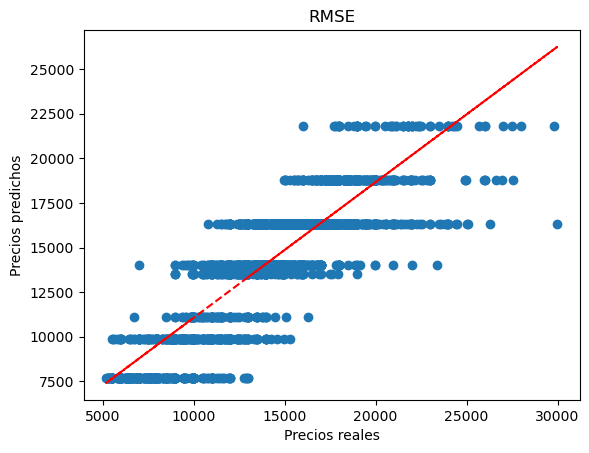

In [17]:
# Ajustar una línea de tendencia
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)

# Graficar la dispersión y la línea de tendencia
plt.scatter(y_test, y_pred)
plt.plot(y_test, p(y_test), "r--")
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('RMSE')
plt.show()

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [18]:
# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))


Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [19]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [20]:
# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

In [21]:
# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(columns=['Price'])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, 0:]
    y_train = y_train.iloc[sample]
    treereg.fit(X_train, y_train)
    y_pred_i = treereg.predict(X_test)
    y_pred['Price' + str(i+1)] = y_pred_i

In [22]:
y_pred = y_pred.drop(['Price'], axis=1)

In [23]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2094.921651442501
Árbol  2 tiene un error:  2143.588943820465
Árbol  3 tiene un error:  2091.5765590558344
Árbol  4 tiene un error:  2101.269034680839
Árbol  5 tiene un error:  2166.1579741770674
Árbol  6 tiene un error:  2167.965320861841
Árbol  7 tiene un error:  2160.523932246401
Árbol  8 tiene un error:  2160.7735197631982
Árbol  9 tiene un error:  2133.42356958019


In [24]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

0       13038.1
1        6493.0
2       16491.0
3       17744.6
4       15988.0
         ...   
3459    15878.6
3460    15515.1
3461    19449.9
3462    12989.0
3463    11933.5
Length: 3464, dtype: float64

In [25]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

1862.899085321319

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [26]:
features = X.columns
n_features=len(features)

clfBag = BaggingRegressor(n_estimators=10, max_features=max(1, int(log(n_features))))
clfBag.fit(X_train, y_train)


BaggingRegressor(max_features=2)

In [27]:
prediccionclfBag = clfBag.predict(X_test)
MSE_clfBag = mean_squared_error(y_test, prediccionclfBag)

print('\nMSE Bagging librería:')
print(MSE_clfBag)


MSE Bagging librería:
6642726.20583384


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [28]:
clfRF = RandomForestRegressor(n_estimators=100, max_features=n_features, random_state=1, n_jobs=-1)
clfRF.fit(X_train, y_train)

RandomForestRegressor(max_features=9, n_jobs=-1, random_state=1)

In [29]:
prediccionclfRF = clfRF.predict(X_test)
MSE_clfRF = mean_squared_error(y_test, prediccionclfRF)
print('\nMSE Random Forest librería:')
print(MSE_clfRF)


MSE Random Forest librería:
3824581.0204909546


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### Calibración max_depth

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

depth_range = range(1,11)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=0, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())


Text(0, 0.5, 'Accuracy')

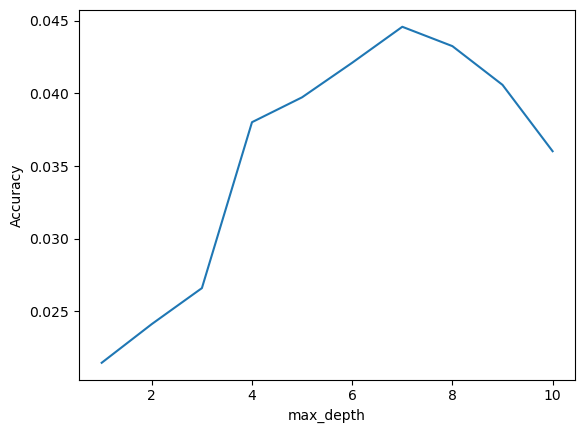

In [9]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# El accuracy tuvo su max en max_depth=7

#### Calibración max_features

In [10]:
feature_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(max_depth=7, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

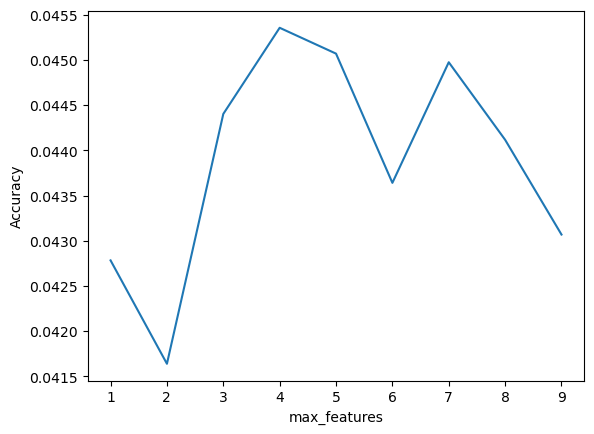

In [11]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

# Accuracy llegó al su max en max_features=4

#### Calibración n_estimators

In [12]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 400, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(max_depth=7, max_features=4, n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

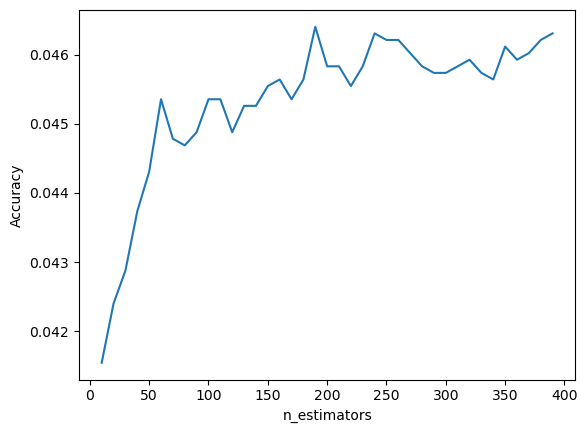

In [13]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

#### Implementación del Random Forest con los mejores parámetros

In [14]:
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
clf = RandomForestClassifier(max_depth=7, max_features=4, n_estimators=200, random_state=1, n_jobs=-1)
#clf.fit(X, y)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=4, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [15]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':X.columns, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
5,M_CamryL,0.008146
4,M_CamryBase,0.008550
2,M_Camry,0.012972
3,M_Camry4dr,0.014180
6,M_CamryLE,0.028657
8,M_CamryXLE,0.029464
7,M_CamrySE,0.043550
0,Year,0.207461
1,Mileage,0.647021


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [16]:
# Celda 6

# Implementando un Modelo XGBoost Clasificador con parametros por default
xgb_reg = XGBRegressor()
xgb_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [17]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
xgb_reg.fit(X_train, y_train)

y_pred_xgb_default = xgb_reg.predict(X_test)

# Variance_score
print("Varianza: %f" % (explained_variance_score(y_pred_xgb_default, y_test)))

# RMSE
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test, y_pred_xgb_default))))

# MAE
print('MAE: %f' % (mean_absolute_error(y_test, y_pred_xgb_default)))

Varianza: 0.799914
RMSE: 1621.419700
MAE: 1186.634392


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

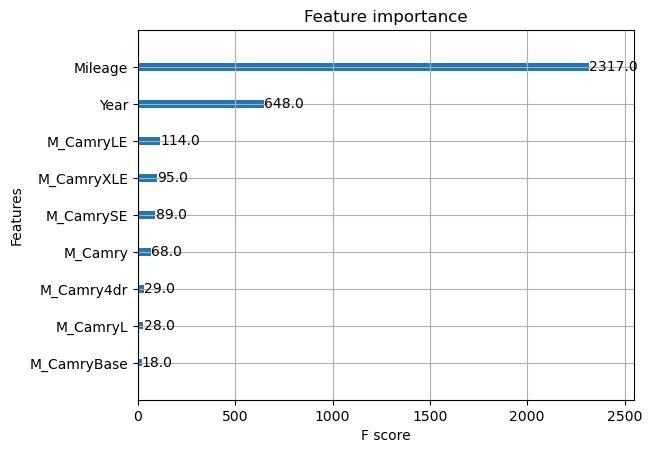

In [18]:
plot_importance(xgb_reg)

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [19]:
# Celda 7
# Para realizar la calibración se utiliza una implementacion 'Grid Search Cross-Validation'
from sklearn.model_selection import GridSearchCV

xgb_reg = XGBRegressor()

# Definir la cuadrícula de parámetros
param_grid = {
    'gamma': [0, 0.1, 0.5],
    'learning_rate': [0.01, 0.1, 0.5],
    'colsample_bytree': [0.5, 0.7, 1],
    'n_estimators': [100],
}

# Se aplica la estrategia GridSearch
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=6, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros encontrados
print("Mejores parametros encontrados: ", grid_search.best_params_)
print("RMSE más bajo encontrado: ", np.sqrt(np.abs(grid_search.best_score_)))

Mejores parametros encontrados:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 100}
RMSE más bajo encontrado:  1506.871586560567


In [20]:
# Implementando un Modelo XGBoost Clasificador con parametros learning rate, gamma y colsample_bytree calibrados
xgb_reg_calibrado = XGBRegressor(gamma=0, learning_rate=0.1, colsample_bytree=0.5, n_estimators=100)
xgb_reg_calibrado

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier Calibrado
xgb_reg_calibrado.fit(X_train, y_train)

y_pred_xgb_calibrado = xgb_reg_calibrado.predict(X_test)

# Variance_score
print("Varianza: %f" % (explained_variance_score(y_pred_xgb_calibrado, y_test)))

# RMSE
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test, y_pred_xgb_calibrado))))

# MAE
print('MAE: %f' % (mean_absolute_error(y_test, y_pred_xgb_calibrado)))

Varianza: 0.815204
RMSE: 1543.917924
MAE: 1132.651474


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

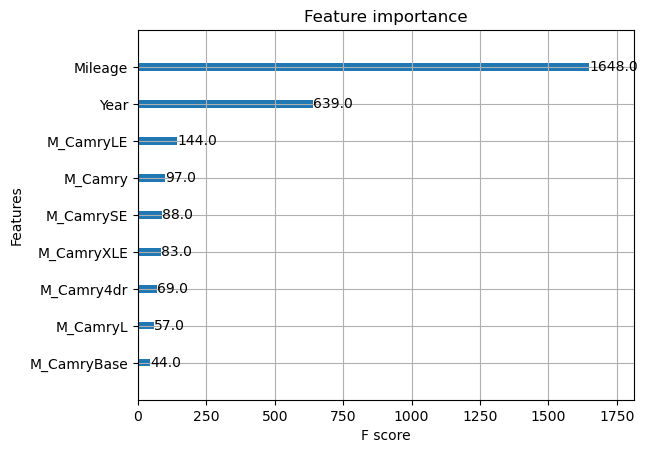

In [22]:
plot_importance(xgb_reg_calibrado)

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [30]:
# Celda 8
